In [7]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import os
import pathlib
import pandas as pd

# Инициализация GPU

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


# Parameters

In [4]:
dir_path = pathlib.Path.cwd()
dir_path = str(dir_path)
dir_path

'H:\\IntensiveGitHub\\Intensive'

In [8]:
DATASET_DIR = "All/"
NUM_CLASSES = 25

IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300

IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 75
NUM_WORKERS = 2
EPOCHS = 8

In [27]:
classes = os.listdir(DATASET_DIR)
classes.sort()
labels = pd.DataFrame({
    'Name': classes
})
labels = labels.reset_index()
labels

,Name
0,Baked_cheese_omelet
1,Bread_made_from_wheat_flour
2,Butter
3,Casserole
4,Cheese
5,Cheese_casserole
6,Cheese_sandwich
7,Cherry_Sauce
8,Coffee
9,Compote


In [33]:
labels.to_csv('labels.csv', encoding='utf8')

# Wrapping for dataset

In [ ]:
label_path = 'labels/labels.csv'
image_names, labels = _load_labels(label_path)

In [46]:
class All_Food_Drink(Dataset):
    def __init__(self, dataset_dir: str, image_height: int, image_width: int, train: bool = False):
        super(All_Food_Drink, self).__init__()
        self.dataset_dir = dataset_dir
        self.image_height = image_height
        self.image_width = image_width
        self.train = train

        # dir_suffix = 'train' if self.train else 'test'
        # label_name = 'TsignRecgTrain4170Annotation.txt' if self.train else 'TsignRecgTest1994Annotation.txt'

        # self.image_dir = f'{self.dataset_dir}/images_{dir_suffix}/'
        # self.label_path = f'{self.dataset_dir}/annotations_{dir_suffix}/{label_name}'
        self.image_dir = f'{self.dataset_dir}/'
        self.label_path = 'labels/labels.csv'

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
            ]
        )

    def __getitem__(self, index):
        image = self.get_np_image(index)
        image = np.array(image / 255, dtype=np.float32)
        image = self.transform(image)
        label = self.labels[index]
        return image, label

    def get_np_image(self, index):
        image = cv2.imread(f'{self.image_dir}/{self.image_names[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x1, y1, x2, y2 = self.x1y1x2y2s[index]
        image = image[y1: y2, x1: x2, ...]
        image = cv2.resize(image, (self.image_width, self.image_height), interpolation=cv2.INTER_CUBIC)
        return image

    def __len__(self):
        return len(self.image_names)

In [47]:
def create_dataloader(dataset: Dataset, batch_size: int, num_workers: int, train: bool = False):
    return DataLoader(
        dataset=dataset, batch_size=batch_size,
        shuffle=train, num_workers=num_workers,
        pin_memory=True, drop_last=False)


def evaluate(model: nn.Module, dataloader: DataLoader, train: bool = False):
    model.eval()

    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    images = len(dataloader) * dataloader.batch_size
    prefix = "train" if train else "test"
    print(f'Accuracy of the network on the {images} {prefix} images: {(100 * correct / total):.2f} %')


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Dataset instances

In [48]:
train_dataset = All_Food_Drink(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH, train=True)

test_dataset = All_Food_Drink(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH)

train_dataloader = create_dataloader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, train=True)

test_dataloader = create_dataloader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

IndexError: list index out of range

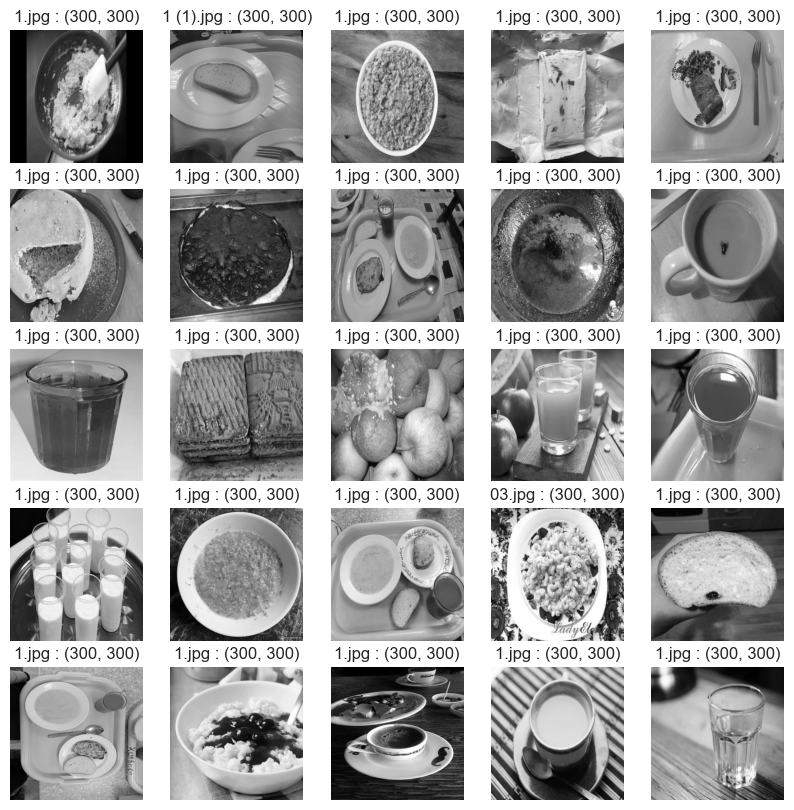

In [8]:
indices = [0, 200, 400, 600, 800, 1000]
plot([train_dataset.get_np_image(index) for index in indices]);

In [11]:
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [12]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels) !!!!!!
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )


    # Split into training (70% and testing (30%) datasets)
    # Split into training (80% and testing (20%) datasets) !
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    train_dataset, test_dataset = train_test_split(full_dataset, test_size=0.2, train_size=0.8, random_state=42)

    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=75,
        # batch_size=50,
        # batch_size=34,
        num_workers=0,
        shuffle=False
    )

    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=75,
        # batch_size=50,
        # batch_size=34,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

Data loaders ready


In [21]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# компиляция модели многолассовой классификации
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 148, 148, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 74, 74, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 72, 72, 64)      

In [22]:
early_stopping = EarlyStopping(patience=10)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, factor = 0.5, min_lr = 0.00001)
callbacks = [early_stopping, reduce_lr]

In [23]:
!nvidia-smi

Wed Dec 14 16:07:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 26%   36C    P8     6W / 100W |    104MiB /  4096MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
with tf.compat.v1.Session() as sess:
    devices = sess.list_devices()

In [25]:
with tf.device('/gpu:0'):
    history = model.fit_generator(
        train_loader,
        epochs = 10,
        validation_data = test_loader,
        callbacks = callbacks
    )

ValueError: Failed to find data adapter that can handle input: <class 'torch.utils.data.dataloader.DataLoader'>, <class 'NoneType'>